In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

import pandas

#from pushover import notify
from sksq96Utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

#%load_ext autoreload
#%autoreload 2

In [2]:
# Device configuration
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


In [3]:
bs = 32

In [4]:
# Load Data
dataset = torchvision.datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(300000, 9375)

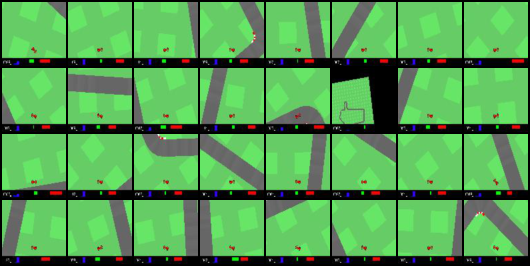

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [8]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        esp = esp.to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
image_channels = fixed_x.size(1)

In [10]:
model = VAE(image_channels=image_channels).to(device)
model.load_state_dict(torch.load('vae.torch', map_location=device))
model=model.to(device)
#model.load_state_dict(torch.load('vae.torch'))

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [12]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
!rm -rfr reconstructed
!mkdir reconstructed

In [13]:
epochs = 5

In [14]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #to_print = "Loss: {:.3f} {:.3f} {:.3f}".format(loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
        
        #
    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
    print(to_print)
    #print(epoch)

# notify to android when finished training
# notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

D:\Users\Kristopher_2\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

In [15]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

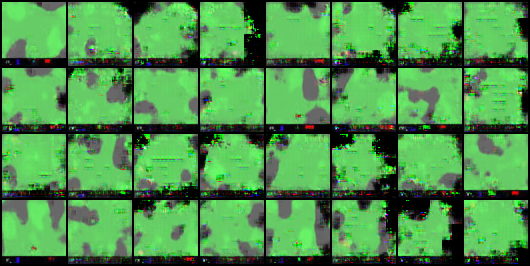

In [16]:
sample = torch.randn(bs, 1024).to(device)
compare_x = model.decoder(sample).to(device)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
#fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
#compare_x = compare(fixed_x)

#save_image(compare_x.data.cuda(), 'sample_image.png')
#display(Image('sample_image.png', width=700, unconfined=True))

save_image(compare_x, 'sample_image.png')
Image('sample_image.png')

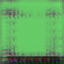

In [54]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x[:1][0].unsqueeze(0).to(device)
#fixed_x = dataset[randint(1, 100)][0].unsqueeze(0).to(device)

sample = model.encoder(fixed_x).to(device)
#sample = torch.randn(bs, 1024).to(device)
compare_x = model.decoder(sample).to(device)

#compare_x = model.encoder(fixed_x).to(device)
#decoder_x = model.decoder(compare_x).to(device)
save_image(compare_x, 'real_image.png')

Image('real_image.png')

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
#fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
#compare_x = compare(fixed_x)

#save_image(compare_x.data.cuda(), 'sample_image.png')
#display(Image('sample_image.png', width=700, unconfined=True))

#save_image(compare_x, 'sample_image.png')
#Image('sample_image.png')

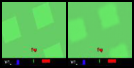

In [31]:
vae = model
fixed_x, _ = next(iter(dataloader))
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0).to(device)
compare_x = compare(fixed_x)

save_image(compare_x, 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))